In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold
import lightgbm as lgb
import xgboost as xgb
import sklearn

In [2]:
train_ = pd.read_pickle('../input/amexfeatureengineeringdataset/train_.pkl')
trainY = pd.read_pickle('../input/amexfeatureengineeringdataset/trainY.pkl')

In [3]:
train_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Columns: 751 entries, record to P_B_ratio
dtypes: float16(494), float64(245), int64(12)
memory usage: 1.3+ GB


In [4]:
shy_cat = pd.read_pickle('../input/cat-feature/shy_train.pkl')
# shy_cat.fillna(0,inplace=True)
shy_cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   b30func1   458913 non-null  float16
 1   b30func2   458913 non-null  float16
 2   b30func3   458913 non-null  float16
 3   b30func4   456897 non-null  float16
 4   b30func5   458913 non-null  float16
 5   b30func6   456897 non-null  float16
 6   b38func1   458913 non-null  float16
 7   b38func3   458913 non-null  float16
 8   b38func4   458913 non-null  float16
 9   b38func5   458913 non-null  float16
 10  b38func6   458913 non-null  float16
 11  datefunc1  458913 non-null  float16
dtypes: float16(12)
memory usage: 14.0+ MB


In [5]:
train_ = pd.concat([train_,shy_cat],axis=1)

In [6]:
train_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Columns: 763 entries, record to datefunc1
dtypes: float16(506), float64(245), int64(12)
memory usage: 1.3+ GB


In [7]:
del shy_cat
gc.collect()

66

In [8]:
train_ = train_.reset_index()
train_.pop('customer_ID')

0         0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...
1         00000fd6641609c6ece5454664794f0340ad84dddce9a2...
2         00001b22f846c82c51f6e3958ccd81970162bae8b007e8...
3         000041bdba6ecadd89a52d11886e8eaaec9325906c9723...
4         00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...
                                ...                        
458908    ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...
458909    ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...
458910    ffff9984b999fccb2b6127635ed0736dda94e544e67e02...
458911    ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...
458912    fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...
Name: customer_ID, Length: 458913, dtype: object

In [9]:
train_.head()

,record,P_2,P_2_trend,D_39,D_39_last,D_39_trend,B_1,B_1_max,B_1_min,B_1_last,...,b30func3,b30func4,b30func5,b30func6,b38func1,b38func3,b38func4,b38func5,b38func6,datefunc1
0,4,0.933594,-0.000300,0.010704,0.009117,0.000568,0.012009,0.021652,0.001930,0.009384,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,369.0
1,4,0.899902,-0.003756,0.215210,0.178101,-0.015747,0.025650,0.109619,0.006710,0.034698,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,389.0
2,4,0.878418,0.000338,0.004181,0.009705,0.000634,0.004387,0.009995,0.001472,0.004284,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,366.0
3,4,0.599121,0.004169,0.048859,0.001082,-0.020575,0.059875,0.280029,0.005909,0.012566,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,363.0
4,4,0.891602,-0.004995,0.004642,0.005573,-0.000077,0.005939,0.009804,0.000776,0.007679,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,365.0


In [10]:
# feature selection

import matplotlib.pyplot as plt
# from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# Create the RFE object and compute a cross-validated score.
# svc = SVC(kernel="linear")
# The "accuracy" scoring shows the proportion of correct classifications
gbm = lgb.LGBMClassifier(
    objective='binary', 
    boosting_type='gbdt',
    max_depth=5, 
    learning_rate=0.1,
    n_estimators=200,
    min_child_samples = 200,
    subsample = 0.4,
    colsample_bytree = 0.25,
    reg_alpha = 50,
    reg_lambda = 50,
    # n_jobs = 4,
    random_state = 0
)

min_features_to_select = 400  # Minimum number of features to consider

rfecv = RFECV(
    estimator=gbm,
    step=100,
    cv=StratifiedKFold(5),
    scoring="neg_root_mean_squared_error",
    min_features_to_select=min_features_to_select,
    verbose = 100
)

rfecv.fit(train_, trainY)  

Fitting estimator with 763 features.
Fitting estimator with 663 features.
Fitting estimator with 563 features.
Fitting estimator with 463 features.
Fitting estimator with 763 features.
Fitting estimator with 663 features.
Fitting estimator with 563 features.
Fitting estimator with 463 features.
Fitting estimator with 763 features.
Fitting estimator with 663 features.
Fitting estimator with 563 features.
Fitting estimator with 463 features.
Fitting estimator with 763 features.
Fitting estimator with 663 features.
Fitting estimator with 563 features.
Fitting estimator with 463 features.
Fitting estimator with 763 features.
Fitting estimator with 663 features.
Fitting estimator with 563 features.
Fitting estimator with 463 features.
Fitting estimator with 763 features.
Fitting estimator with 663 features.
Fitting estimator with 563 features.


RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(colsample_bytree=0.25, max_depth=5,
                               min_child_samples=200, n_estimators=200,
                               objective='binary', random_state=0, reg_alpha=50,
                               reg_lambda=50, subsample=0.4),
      min_features_to_select=400, scoring='neg_root_mean_squared_error',
      step=100, verbose=100)

Optimal number of features : 463


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


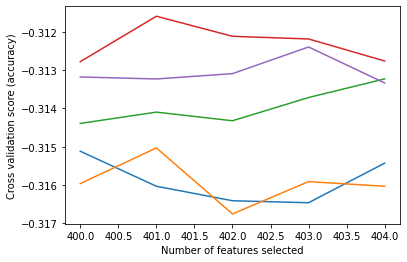

In [11]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [12]:
selected1 = rfecv.get_support()
selected1 = rfecv.support_

In [13]:
train_ = train_.iloc[:,selected1]

In [14]:
# del train
# gc.collect()

  

In [15]:
# model robustness indicator
def calc_vdr(pred, actual, vdr_cutoff = 0.2):
    # Function to calculate VDR at a given cutoff

    df_vdr_train = pd.DataFrame(zip(pred), columns = ['predicted_proba'])
    df_vdr_train['actual'] = np.array(actual)
    df_vdr_train = df_vdr_train.sort_values(by = 'predicted_proba', ascending = False)
    num_bad = df_vdr_train['actual'].sum()
    top_20_pct = int(len(df_vdr_train['actual'])*vdr_cutoff)
    vdr = df_vdr_train.head(top_20_pct)['actual'].sum()/num_bad
    return vdr

# evaluation matrix

# 4% cutoff measures the true positive rate of the 4% data
# positives are given 20x weights
# cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
# the code above indicates that if we successfully detect more positive cases, we will get less cut_samples
# since negative samples have weight of 1, we should have more samples to let cut_vals reach threshold
# the top four value equals to the ture positive numbers in cut_vals samples/the number of all true positive samples
# therefore, our models should be more sensitive to true positive cases and have a larger true positive rate

# gini = 2(ROC-0.5)

def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    print(f'Top four({len(cut_vals[:,0])} total cases) has {top_four*100}% positives cases being predicted')    

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)
    print(f'Gini value is {gini[1]/gini[0]}')
    
    
    return 0.5 * (gini[1]/gini[0] + top_four)

In [16]:
modelNum = [2022,725,514]
performanceROC = []
performanceSCORE = []
blended = []

for _ in modelNum:
    folds = StratifiedKFold(n_splits= 5, shuffle=True, random_state=_)
    models = []
    lgb_performance_roc = []
    lgb_performance_score = []
    xgb_performance_roc = []
    xgb_performance_score = []

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_, trainY)):
        train_x, train_y = train_.iloc[train_idx], trainY.iloc[train_idx]
        valid_x, valid_y = train_.iloc[valid_idx], trainY.iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization

        gbm = lgb.LGBMClassifier(
            objective='binary', 
            boosting_type='gbdt',
            max_depth=10, 
            learning_rate=0.1,
            n_estimators=1600,
            class_weight = {1:1,0:1},
            min_child_samples = 1000,
            subsample = 0.3,
            colsample_bytree = 0.1,
            reg_alpha = 10,
            reg_lambda = 5,
            # n_jobs = 4,
            random_state = _            
        )
        gbm.fit(train_x, 
                train_y, 
                eval_set=[(valid_x, valid_y)], 
                eval_metric='rmse', 
                early_stopping_rounds=100,
                verbose = 100)
        
        xgbc = xgb.XGBClassifier(
            n_estimators=600, 
            learning_rate=0.1, 
            subsample=0.3, 
            seed=_, 
            max_depth=10,
            colsample_bytree=0.1, 
            reg_alpha=1, 
            reg_lambda=1)

        xgbc.fit(train_x, 
                 train_y, 
                 eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                 eval_metric= 'aucpr',
                 verbose=100)
        
        # gbm evaluation
        train_score_lgm = gbm.predict_proba(train_x)[:,1]
        valid_score_lgm = gbm.predict_proba(valid_x)[:,1]
        roc_auc_train = sklearn.metrics.roc_auc_score(train_y, train_score_lgm)
        roc_auc_valid = sklearn.metrics.roc_auc_score(valid_y, valid_score_lgm)
        score_train = amex_metric_mod(train_y, train_score_lgm)
        score_valid = amex_metric_mod(valid_y, valid_score_lgm)
        lgb_performance_roc.append(roc_auc_valid)
        lgb_performance_score.append(score_valid)
        performanceROC.append(roc_auc_valid)
        performanceSCORE.append(score_valid)
        print('LGB - METRICS')
        print('LGB: Train_score: {:.4f} valid_score: {:.4f}'.format(roc_auc_train , roc_auc_valid))
        print(f'LGB: train_vdr score: {calc_vdr(train_score_lgm,actual=train_y)}')
        print(f'LGB: valid_vdr score: {calc_vdr(valid_score_lgm,actual=valid_y)}')
        #joblib.dump(gbm,'./model_shy/lgm'+str(round(sklearn.metrics.roc_auc_score(valid_y, valid_score_lgm),5)).replace('0.','')+'.model')
        print('LGB: Train_score: {:.4f} valid_score: {:.4f}'.format(score_train, score_valid))
        
        # xgboost evaluation
        train_score_lgm = xgbc.predict_proba(train_x)[:,1]
        valid_score_lgm = xgbc.predict_proba(valid_x)[:,1]
        roc_auc_train = sklearn.metrics.roc_auc_score(train_y, train_score_lgm)
        roc_auc_valid = sklearn.metrics.roc_auc_score(valid_y, valid_score_lgm)
        score_train = amex_metric_mod(train_y, train_score_lgm)
        score_valid = amex_metric_mod(valid_y, valid_score_lgm)
        xgb_performance_roc.append(roc_auc_valid)
        xgb_performance_score.append(score_valid)
        performanceROC.append(roc_auc_valid)
        performanceSCORE.append(score_valid)
        print('XGB - METRICS')
        print('XGB: Train_score: {:.4f} valid_score: {:.4f}'.format(roc_auc_train , roc_auc_valid))
        print(f'XGB: train_vdr score: {calc_vdr(train_score_lgm,actual=train_y)}')
        print(f'XGB: valid_vdr score: {calc_vdr(valid_score_lgm,actual=valid_y)}')
        #joblib.dump(gbm,'./model_shy/lgm'+str(round(sklearn.metrics.roc_auc_score(valid_y, valid_score_lgm),5)).replace('0.','')+'.model')
        print('XGB: Train_score: {:.4f} valid_score: {:.4f}'.format(score_train, score_valid))
        
        # combined
        valid_score = np.mean(np.array([gbm.predict_proba(valid_x)[:,1],xgbc.predict_proba(valid_x)[:,1]]),axis=0)
        roc_auc_valid = sklearn.metrics.roc_auc_score(valid_y, valid_score)
        score_valid = amex_metric_mod(valid_y, valid_score)
        print('Combined - METRICS')
        print('Combined: roc_valid_score: {:.4f}'.format(roc_auc_valid))
        print('Combined: valid_score: {:.4f}'.format(score_valid))
        
        models.append([gbm,xgbc])
        
        del train_x, train_y, valid_x, valid_y
        gc.collect()
        
    print(f'Model_{_} ROC: avg={np.mean(lgb_performance_roc)}   std={np.std(lgb_performance_roc)}')
    print(f'Model_{_} ROC: avg={np.mean(xgb_performance_roc)}   std={np.std(xgb_performance_roc)}')

    print(f'Model_{_} SCORE: avg={np.mean(lgb_performance_score)}   std={np.std(lgb_performance_score)}')
    print(f'Model_{_} SCORE: avg={np.mean(xgb_performance_score)}   std={np.std(xgb_performance_score)}')

    print('***********************************')
    blended.append(models)
    
print('******************************************')
print(f'Models Weighted ROC: avg={np.mean(performanceROC)}')
print(f'Models Weighted SCORE: avg={np.mean(performanceSCORE)}')
dfROC = pd.DataFrame({'ROC_1':performanceROC[0:10],'ROC_2':performanceROC[10:20],'ROC_3':performanceROC[20:30]})
dfSCORE = pd.DataFrame({'SCORE_1':performanceSCORE[0:10],'SCORE_2':performanceSCORE[10:20],'SCORE_3':performanceSCORE[20:30]})
print(dfROC)
print(dfSCORE)
del train_
gc.collect()

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 0.266339	valid_0's binary_logloss: 0.226782
[200]	valid_0's rmse: 0.263595	valid_0's binary_logloss: 0.222205
[300]	valid_0's rmse: 0.262737	valid_0's binary_logloss: 0.22088
[400]	valid_0's rmse: 0.262368	valid_0's binary_logloss: 0.220299
[500]	valid_0's rmse: 0.262208	valid_0's binary_logloss: 0.220036
[600]	valid_0's rmse: 0.262117	valid_0's binary_logloss: 0.21989
[700]	valid_0's rmse: 0.262067	valid_0's binary_logloss: 0.219802
[800]	valid_0's rmse: 0.262069	valid_0's binary_logloss: 0.219835


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-aucpr:0.81956	validation_1-aucpr:0.79682
[100]	validation_0-aucpr:0.94593	validation_1-aucpr:0.88699
[200]	validation_0-aucpr:0.97296	validation_1-aucpr:0.88639
[300]	validation_0-aucpr:0.98703	validation_1-aucpr:0.88525
[400]	validation_0-aucpr:0.99486	validation_1-aucpr:0.88429
[500]	validation_0-aucpr:0.99833	validation_1-aucpr:0.88440
[599]	validation_0-aucpr:0.99957	validation_1-aucpr:0.88431
Top four(80534 total cases) has 76.9161179020008% positives cases being predicted
Gini value is 0.9507921546299857
Top four(17478 total cases) has 65.15610536059917% positives cases being predicted
Gini value is 0.9216597690256777
LGB - METRICS
LGB: Train_score: 0.9754 valid_score: 0.9608
LGB: train_vdr score: 0.7166691212051083
LGB: valid_vdr score: 0.6775645880669865
LGB: Train_score: 0.8600 valid_score: 0.7866
Top four(101263 total cases) has 99.86955881424754% positives cases being predicted
Gini value is 0.9996779623831099
Top four(16898 total cases) has 62.5852057561221

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 0.265403	valid_0's binary_logloss: 0.225575
[200]	valid_0's rmse: 0.262808	valid_0's binary_logloss: 0.221337
[300]	valid_0's rmse: 0.262014	valid_0's binary_logloss: 0.220084
[400]	valid_0's rmse: 0.261733	valid_0's binary_logloss: 0.219659
[500]	valid_0's rmse: 0.26162	valid_0's binary_logloss: 0.219485
[600]	valid_0's rmse: 0.261641	valid_0's binary_logloss: 0.219512


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-aucpr:0.82031	validation_1-aucpr:0.80215
[100]	validation_0-aucpr:0.94601	validation_1-aucpr:0.88806
[200]	validation_0-aucpr:0.97223	validation_1-aucpr:0.88748
[300]	validation_0-aucpr:0.98653	validation_1-aucpr:0.88615
[400]	validation_0-aucpr:0.99473	validation_1-aucpr:0.88538
[500]	validation_0-aucpr:0.99825	validation_1-aucpr:0.88509
[599]	validation_0-aucpr:0.99954	validation_1-aucpr:0.88464
Top four(78347 total cases) has 74.49348846016284% positives cases being predicted
Gini value is 0.9446252045748313
Top four(17562 total cases) has 65.52638222671042% positives cases being predicted
Gini value is 0.9218140311065827
LGB - METRICS
LGB: Train_score: 0.9723 valid_score: 0.9609
LGB: train_vdr score: 0.7086112221497549
LGB: valid_vdr score: 0.6783640494824539
LGB: Train_score: 0.8448 valid_score: 0.7885
Top four(101246 total cases) has 99.8506238034125% positives cases being predicted
Gini value is 0.9996498434770776
Top four(16851 total cases) has 62.3790288647647

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 0.263738	valid_0's binary_logloss: 0.223112
[200]	valid_0's rmse: 0.261188	valid_0's binary_logloss: 0.21902
[300]	valid_0's rmse: 0.260451	valid_0's binary_logloss: 0.217848
[400]	valid_0's rmse: 0.260186	valid_0's binary_logloss: 0.21746
[500]	valid_0's rmse: 0.260088	valid_0's binary_logloss: 0.217301
[600]	valid_0's rmse: 0.260013	valid_0's binary_logloss: 0.217196


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-aucpr:0.81686	validation_1-aucpr:0.80697
[100]	validation_0-aucpr:0.94570	validation_1-aucpr:0.89065
[200]	validation_0-aucpr:0.97201	validation_1-aucpr:0.88948
[300]	validation_0-aucpr:0.98709	validation_1-aucpr:0.88749
[400]	validation_0-aucpr:0.99505	validation_1-aucpr:0.88646
[500]	validation_0-aucpr:0.99839	validation_1-aucpr:0.88624
[599]	validation_0-aucpr:0.99957	validation_1-aucpr:0.88615
Top four(78802 total cases) has 74.99737013738402% positives cases being predicted
Gini value is 0.9460839010409775
Top four(17766 total cases) has 66.43103593368677% positives cases being predicted
Gini value is 0.9236003595260045
LGB - METRICS
LGB: Train_score: 0.9730 valid_score: 0.9618
LGB: train_vdr score: 0.7107466705939282
LGB: valid_vdr score: 0.6803837414794244
LGB: Train_score: 0.8480 valid_score: 0.7940
Top four(101265 total cases) has 99.87166270434032% positives cases being predicted
Gini value is 0.9996767846497464
Top four(17104 total cases) has 63.498274846419

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 0.264873	valid_0's binary_logloss: 0.224817
[200]	valid_0's rmse: 0.26247	valid_0's binary_logloss: 0.220759
[300]	valid_0's rmse: 0.261681	valid_0's binary_logloss: 0.219522
[400]	valid_0's rmse: 0.261404	valid_0's binary_logloss: 0.219063
[500]	valid_0's rmse: 0.261288	valid_0's binary_logloss: 0.218901
[600]	valid_0's rmse: 0.261242	valid_0's binary_logloss: 0.218847
[700]	valid_0's rmse: 0.261191	valid_0's binary_logloss: 0.218806


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-aucpr:0.81833	validation_1-aucpr:0.80276
[100]	validation_0-aucpr:0.94667	validation_1-aucpr:0.88898
[200]	validation_0-aucpr:0.97250	validation_1-aucpr:0.88739
[300]	validation_0-aucpr:0.98764	validation_1-aucpr:0.88594
[400]	validation_0-aucpr:0.99502	validation_1-aucpr:0.88545
[500]	validation_0-aucpr:0.99839	validation_1-aucpr:0.88503
[599]	validation_0-aucpr:0.99959	validation_1-aucpr:0.88500
Top four(80133 total cases) has 76.47034072141632% positives cases being predicted
Gini value is 0.9499357081205997
Top four(17656 total cases) has 65.945718493583% positives cases being predicted
Gini value is 0.9223288647874691
LGB - METRICS
LGB: Train_score: 0.9750 valid_score: 0.9612
LGB: train_vdr score: 0.715283548804477
LGB: valid_vdr score: 0.6797391121397013
LGB: Train_score: 0.8573 valid_score: 0.7909
Top four(101266 total cases) has 99.87166405436395% positives cases being predicted
Gini value is 0.9996841041483411
Top four(16936 total cases) has 62.756154007994944

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 0.265495	valid_0's binary_logloss: 0.226114
[200]	valid_0's rmse: 0.263054	valid_0's binary_logloss: 0.22207
[300]	valid_0's rmse: 0.26217	valid_0's binary_logloss: 0.220704
[400]	valid_0's rmse: 0.261827	valid_0's binary_logloss: 0.220176
[500]	valid_0's rmse: 0.261774	valid_0's binary_logloss: 0.220121


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-aucpr:0.81902	validation_1-aucpr:0.80100
[100]	validation_0-aucpr:0.94694	validation_1-aucpr:0.88915
[200]	validation_0-aucpr:0.97307	validation_1-aucpr:0.88760
[300]	validation_0-aucpr:0.98782	validation_1-aucpr:0.88628
[400]	validation_0-aucpr:0.99503	validation_1-aucpr:0.88532
[500]	validation_0-aucpr:0.99835	validation_1-aucpr:0.88489
[599]	validation_0-aucpr:0.99956	validation_1-aucpr:0.88461
Top four(77258 total cases) has 73.28718849604999% positives cases being predicted
Gini value is 0.9421750273712681
Top four(17670 total cases) has 66.00883652430043% positives cases being predicted
Gini value is 0.9213597951015777
LGB - METRICS
LGB: Train_score: 0.9711 valid_score: 0.9607
LGB: train_vdr score: 0.7046274575807623
LGB: valid_vdr score: 0.6801178203240059
LGB: Train_score: 0.8375 valid_score: 0.7907
Top four(101250 total cases) has 99.85378117669335% positives cases being predicted
Gini value is 0.9996639970565604
Top four(16876 total cases) has 62.491058278981

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 0.264564	valid_0's binary_logloss: 0.224165
[200]	valid_0's rmse: 0.261933	valid_0's binary_logloss: 0.219761
[300]	valid_0's rmse: 0.261163	valid_0's binary_logloss: 0.218496
[400]	valid_0's rmse: 0.260888	valid_0's binary_logloss: 0.21801
[500]	valid_0's rmse: 0.260712	valid_0's binary_logloss: 0.217706
[600]	valid_0's rmse: 0.260677	valid_0's binary_logloss: 0.217676


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-aucpr:0.81446	validation_1-aucpr:0.80143
[100]	validation_0-aucpr:0.94604	validation_1-aucpr:0.89037
[200]	validation_0-aucpr:0.97258	validation_1-aucpr:0.88881
[300]	validation_0-aucpr:0.98726	validation_1-aucpr:0.88748
[400]	validation_0-aucpr:0.99501	validation_1-aucpr:0.88602
[500]	validation_0-aucpr:0.99838	validation_1-aucpr:0.88570
[599]	validation_0-aucpr:0.99959	validation_1-aucpr:0.88569
Top four(78999 total cases) has 75.2161747070333% positives cases being predicted
Gini value is 0.9462907816217611
Top four(17611 total cases) has 65.74097450138854% positives cases being predicted
Gini value is 0.9230580716449327
LGB - METRICS
LGB: Train_score: 0.9731 valid_score: 0.9615
LGB: train_vdr score: 0.7108203067471756
LGB: valid_vdr score: 0.6795422031473534
LGB: Train_score: 0.8492 valid_score: 0.7902
Top four(101273 total cases) has 99.88007826471144% positives cases being predicted
Gini value is 0.9996939439078015
Top four(16922 total cases) has 62.6903980476310

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 0.266157	valid_0's binary_logloss: 0.226849
[200]	valid_0's rmse: 0.263577	valid_0's binary_logloss: 0.222533
[300]	valid_0's rmse: 0.262701	valid_0's binary_logloss: 0.221158
[400]	valid_0's rmse: 0.262393	valid_0's binary_logloss: 0.220721
[500]	valid_0's rmse: 0.262247	valid_0's binary_logloss: 0.220504
[600]	valid_0's rmse: 0.262254	valid_0's binary_logloss: 0.22055


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-aucpr:0.81707	validation_1-aucpr:0.79936
[100]	validation_0-aucpr:0.94629	validation_1-aucpr:0.88860
[200]	validation_0-aucpr:0.97212	validation_1-aucpr:0.88657
[300]	validation_0-aucpr:0.98762	validation_1-aucpr:0.88483
[400]	validation_0-aucpr:0.99486	validation_1-aucpr:0.88430
[500]	validation_0-aucpr:0.99829	validation_1-aucpr:0.88402
[599]	validation_0-aucpr:0.99955	validation_1-aucpr:0.88389
Top four(78264 total cases) has 74.40196924112684% positives cases being predicted
Gini value is 0.9445572700841468
Top four(17519 total cases) has 65.33703610199446% positives cases being predicted
Gini value is 0.920977947454871
LGB - METRICS
LGB: Train_score: 0.9723 valid_score: 0.9605
LGB: train_vdr score: 0.7084955081946519
LGB: valid_vdr score: 0.6781115879828327
LGB: Train_score: 0.8443 valid_score: 0.7872
Top four(101241 total cases) has 99.84431213313417% positives cases being predicted
Gini value is 0.9996661803323542
Top four(16888 total cases) has 62.5389211478582

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 0.264814	valid_0's binary_logloss: 0.225041
[200]	valid_0's rmse: 0.262034	valid_0's binary_logloss: 0.220614
[300]	valid_0's rmse: 0.261157	valid_0's binary_logloss: 0.219269
[400]	valid_0's rmse: 0.260787	valid_0's binary_logloss: 0.218708
[500]	valid_0's rmse: 0.260632	valid_0's binary_logloss: 0.218442
[600]	valid_0's rmse: 0.260496	valid_0's binary_logloss: 0.218275
[700]	valid_0's rmse: 0.260395	valid_0's binary_logloss: 0.218127
[800]	valid_0's rmse: 0.260478	valid_0's binary_logloss: 0.218229


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-aucpr:0.81533	validation_1-aucpr:0.80010
[100]	validation_0-aucpr:0.94666	validation_1-aucpr:0.88964
[200]	validation_0-aucpr:0.97356	validation_1-aucpr:0.88921
[300]	validation_0-aucpr:0.98708	validation_1-aucpr:0.88843
[400]	validation_0-aucpr:0.99482	validation_1-aucpr:0.88814
[500]	validation_0-aucpr:0.99831	validation_1-aucpr:0.88749
[599]	validation_0-aucpr:0.99956	validation_1-aucpr:0.88755
Top four(80655 total cases) has 77.04971492289243% positives cases being predicted
Gini value is 0.9513729133560747
Top four(17763 total cases) has 66.41420516704535% positives cases being predicted
Gini value is 0.9229384071784684
LGB - METRICS
LGB: Train_score: 0.9757 valid_score: 0.9615
LGB: train_vdr score: 0.7169847047190254
LGB: valid_vdr score: 0.6808465875620634
LGB: Train_score: 0.8609 valid_score: 0.7935
Top four(101249 total cases) has 99.85377963855169% positives cases being predicted
Gini value is 0.9996670760438151
Top four(17170 total cases) has 63.788605570983

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 0.26434	valid_0's binary_logloss: 0.223911
[200]	valid_0's rmse: 0.261807	valid_0's binary_logloss: 0.219664
[300]	valid_0's rmse: 0.261133	valid_0's binary_logloss: 0.2186
[400]	valid_0's rmse: 0.260756	valid_0's binary_logloss: 0.218008
[500]	valid_0's rmse: 0.260664	valid_0's binary_logloss: 0.217872
[600]	valid_0's rmse: 0.260613	valid_0's binary_logloss: 0.217762
[700]	valid_0's rmse: 0.260599	valid_0's binary_logloss: 0.217739
[800]	valid_0's rmse: 0.26066	valid_0's binary_logloss: 0.217865


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-aucpr:0.81383	validation_1-aucpr:0.80058
[100]	validation_0-aucpr:0.94582	validation_1-aucpr:0.89005
[200]	validation_0-aucpr:0.97134	validation_1-aucpr:0.88855
[300]	validation_0-aucpr:0.98635	validation_1-aucpr:0.88748
[400]	validation_0-aucpr:0.99454	validation_1-aucpr:0.88671
[500]	validation_0-aucpr:0.99822	validation_1-aucpr:0.88596
[599]	validation_0-aucpr:0.99951	validation_1-aucpr:0.88602
Top four(80712 total cases) has 77.11202044959659% positives cases being predicted
Gini value is 0.9508321176424804
Top four(17660 total cases) has 65.96254996844098% positives cases being predicted
Gini value is 0.9232448696975389
LGB - METRICS
LGB: Train_score: 0.9754 valid_score: 0.9616
LGB: train_vdr score: 0.7170928752511493
LGB: valid_vdr score: 0.6805386071954554
LGB: Train_score: 0.8610 valid_score: 0.7914
Top four(101241 total cases) has 99.84326183688712% positives cases being predicted
Gini value is 0.9996281722228324
Top four(17079 total cases) has 63.387334315169

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 0.265084	valid_0's binary_logloss: 0.22528
[200]	valid_0's rmse: 0.262658	valid_0's binary_logloss: 0.221157
[300]	valid_0's rmse: 0.261828	valid_0's binary_logloss: 0.219811
[400]	valid_0's rmse: 0.261481	valid_0's binary_logloss: 0.219248
[500]	valid_0's rmse: 0.261325	valid_0's binary_logloss: 0.218932
[600]	valid_0's rmse: 0.261299	valid_0's binary_logloss: 0.218848


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-aucpr:0.81572	validation_1-aucpr:0.79712
[100]	validation_0-aucpr:0.94631	validation_1-aucpr:0.88958
[200]	validation_0-aucpr:0.97277	validation_1-aucpr:0.88782
[300]	validation_0-aucpr:0.98710	validation_1-aucpr:0.88664
[400]	validation_0-aucpr:0.99502	validation_1-aucpr:0.88578
[500]	validation_0-aucpr:0.99841	validation_1-aucpr:0.88544
[599]	validation_0-aucpr:0.99958	validation_1-aucpr:0.88564
Top four(78556 total cases) has 74.72413031358151% positives cases being predicted
Gini value is 0.9456892561299225
Top four(17563 total cases) has 65.53334735956238% positives cases being predicted
Gini value is 0.9220451147969116
LGB - METRICS
LGB: Train_score: 0.9728 valid_score: 0.9610
LGB: train_vdr score: 0.7094873925712423
LGB: valid_vdr score: 0.6776351777824532
LGB: Train_score: 0.8465 valid_score: 0.7887
Top four(101244 total cases) has 99.84746957280962% positives cases being predicted
Gini value is 0.9996823153734505
Top four(17036 total cases) has 63.197980223017

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 0.265122	valid_0's binary_logloss: 0.22583
[200]	valid_0's rmse: 0.262453	valid_0's binary_logloss: 0.221488
[300]	valid_0's rmse: 0.261753	valid_0's binary_logloss: 0.220417
[400]	valid_0's rmse: 0.261506	valid_0's binary_logloss: 0.220077
[500]	valid_0's rmse: 0.2614	valid_0's binary_logloss: 0.219952
[600]	valid_0's rmse: 0.261321	valid_0's binary_logloss: 0.21984


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-aucpr:0.79295	validation_1-aucpr:0.77833
[100]	validation_0-aucpr:0.94573	validation_1-aucpr:0.88909
[200]	validation_0-aucpr:0.97189	validation_1-aucpr:0.88699
[300]	validation_0-aucpr:0.98714	validation_1-aucpr:0.88562
[400]	validation_0-aucpr:0.99490	validation_1-aucpr:0.88443
[500]	validation_0-aucpr:0.99842	validation_1-aucpr:0.88408
[599]	validation_0-aucpr:0.99957	validation_1-aucpr:0.88409
Top four(78975 total cases) has 75.18987608087353% positives cases being predicted
Gini value is 0.9470256739399153
Top four(17664 total cases) has 65.97660523436842% positives cases being predicted
Gini value is 0.92143903988311
LGB - METRICS
LGB: Train_score: 0.9735 valid_score: 0.9607
LGB: train_vdr score: 0.7113567987208348
LGB: valid_vdr score: 0.6789531263149037
LGB: Train_score: 0.8495 valid_score: 0.7906
Top four(101255 total cases) has 99.86009130883002% positives cases being predicted
Gini value is 0.9996711756849359
Top four(16983 total cases) has 62.9596903138938%

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 0.265297	valid_0's binary_logloss: 0.224892
[200]	valid_0's rmse: 0.262816	valid_0's binary_logloss: 0.220814
[300]	valid_0's rmse: 0.262051	valid_0's binary_logloss: 0.21965
[400]	valid_0's rmse: 0.261776	valid_0's binary_logloss: 0.219175
[500]	valid_0's rmse: 0.261605	valid_0's binary_logloss: 0.218877
[600]	valid_0's rmse: 0.261543	valid_0's binary_logloss: 0.218792
[700]	valid_0's rmse: 0.261469	valid_0's binary_logloss: 0.218726


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-aucpr:0.79269	validation_1-aucpr:0.77519
[100]	validation_0-aucpr:0.94598	validation_1-aucpr:0.88990
[200]	validation_0-aucpr:0.97102	validation_1-aucpr:0.88872
[300]	validation_0-aucpr:0.98618	validation_1-aucpr:0.88692
[400]	validation_0-aucpr:0.99445	validation_1-aucpr:0.88634
[500]	validation_0-aucpr:0.99814	validation_1-aucpr:0.88560
[599]	validation_0-aucpr:0.99953	validation_1-aucpr:0.88550
Top four(80068 total cases) has 76.39961288422292% positives cases being predicted
Gini value is 0.9496495447860643
Top four(17609 total cases) has 65.73255911806783% positives cases being predicted
Gini value is 0.9224370405683607
LGB - METRICS
LGB: Train_score: 0.9748 valid_score: 0.9612
LGB: train_vdr score: 0.7149228924280996
LGB: valid_vdr score: 0.6798788184801817
LGB: Train_score: 0.8568 valid_score: 0.7899
Top four(101249 total cases) has 99.85377963855169% positives cases being predicted
Gini value is 0.9996394714585051
Top four(16913 total cases) has 62.652528822687

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 0.264569	valid_0's binary_logloss: 0.224211
[200]	valid_0's rmse: 0.262146	valid_0's binary_logloss: 0.220151
[300]	valid_0's rmse: 0.261342	valid_0's binary_logloss: 0.218873
[400]	valid_0's rmse: 0.261094	valid_0's binary_logloss: 0.218459


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-aucpr:0.79503	validation_1-aucpr:0.77669
[100]	validation_0-aucpr:0.94636	validation_1-aucpr:0.88842
[200]	validation_0-aucpr:0.97172	validation_1-aucpr:0.88818
[300]	validation_0-aucpr:0.98700	validation_1-aucpr:0.88678
[400]	validation_0-aucpr:0.99494	validation_1-aucpr:0.88572
[500]	validation_0-aucpr:0.99835	validation_1-aucpr:0.88507
[599]	validation_0-aucpr:0.99956	validation_1-aucpr:0.88491
Top four(76296 total cases) has 72.22233910500515% positives cases being predicted
Gini value is 0.9391303860996546
Top four(17510 total cases) has 65.2949591853909% positives cases being predicted
Gini value is 0.9224841605321804
LGB - METRICS
LGB: Train_score: 0.9696 valid_score: 0.9612
LGB: train_vdr score: 0.701415918032442
LGB: valid_vdr score: 0.67760666498359
LGB: Train_score: 0.8307 valid_score: 0.7877
Top four(101269 total cases) has 99.87587048452589% positives cases being predicted
Gini value is 0.9996627052842982
Top four(16839 total cases) has 62.32432887318017% 

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 0.264956	valid_0's binary_logloss: 0.22487
[200]	valid_0's rmse: 0.26259	valid_0's binary_logloss: 0.220895
[300]	valid_0's rmse: 0.261838	valid_0's binary_logloss: 0.219712
[400]	valid_0's rmse: 0.261569	valid_0's binary_logloss: 0.219237
[500]	valid_0's rmse: 0.261458	valid_0's binary_logloss: 0.219062
[600]	valid_0's rmse: 0.261346	valid_0's binary_logloss: 0.218942
[700]	valid_0's rmse: 0.261314	valid_0's binary_logloss: 0.218897


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-aucpr:0.79314	validation_1-aucpr:0.77922
[100]	validation_0-aucpr:0.94411	validation_1-aucpr:0.88855
[200]	validation_0-aucpr:0.97193	validation_1-aucpr:0.88694
[300]	validation_0-aucpr:0.98689	validation_1-aucpr:0.88567
[400]	validation_0-aucpr:0.99471	validation_1-aucpr:0.88506
[500]	validation_0-aucpr:0.99827	validation_1-aucpr:0.88454
[599]	validation_0-aucpr:0.99956	validation_1-aucpr:0.88435
Top four(80319 total cases) has 76.6765197816185% positives cases being predicted
Gini value is 0.95033729233665
Top four(17609 total cases) has 65.73532505785819% positives cases being predicted
Gini value is 0.9222809868407613
LGB - METRICS
LGB: Train_score: 0.9752 valid_score: 0.9611
LGB: train_vdr score: 0.7158305544744011
LGB: valid_vdr score: 0.6783925941510625
LGB: Train_score: 0.8586 valid_score: 0.7898
Top four(101262 total cases) has 99.86640438446082% positives cases being predicted
Gini value is 0.999666504063389
Top four(16878 total cases) has 62.49947401641068% 

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 0.264229	valid_0's binary_logloss: 0.224135
[200]	valid_0's rmse: 0.261862	valid_0's binary_logloss: 0.220125
[300]	valid_0's rmse: 0.261068	valid_0's binary_logloss: 0.218875
[400]	valid_0's rmse: 0.26089	valid_0's binary_logloss: 0.218573
[500]	valid_0's rmse: 0.260875	valid_0's binary_logloss: 0.218507
[600]	valid_0's rmse: 0.260799	valid_0's binary_logloss: 0.218374
[700]	valid_0's rmse: 0.260847	valid_0's binary_logloss: 0.218451


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-aucpr:0.79477	validation_1-aucpr:0.77289
[100]	validation_0-aucpr:0.94592	validation_1-aucpr:0.88977
[200]	validation_0-aucpr:0.97216	validation_1-aucpr:0.88835
[300]	validation_0-aucpr:0.98684	validation_1-aucpr:0.88720
[400]	validation_0-aucpr:0.99487	validation_1-aucpr:0.88652
[500]	validation_0-aucpr:0.99845	validation_1-aucpr:0.88624
[599]	validation_0-aucpr:0.99957	validation_1-aucpr:0.88600
Top four(79331 total cases) has 75.58250844177019% positives cases being predicted
Gini value is 0.9476344368511085
Top four(17743 total cases) has 66.32863454660215% positives cases being predicted
Gini value is 0.9225282075479347
LGB - METRICS
LGB: Train_score: 0.9738 valid_score: 0.9613
LGB: train_vdr score: 0.7120751501635757
LGB: valid_vdr score: 0.6808752366926152
LGB: Train_score: 0.8517 valid_score: 0.7929
Top four(101251 total cases) has 99.85483311067398% positives cases being predicted
Gini value is 0.9996740605778944
Top four(17019 total cases) has 63.122238586156

0

In [17]:
# test = pd.read_feather('../input/amexfeather/test_data.ftr')                          

In [18]:
# # Engineering - New
# for i in ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']:
#     mapping = test[i].value_counts()
#     test[i] = test[i].map(mapping)
#     test[i] = test[i].astype('float16').fillna(0,inplace=True)

# test['weighted1'] = 0
# test['weighted2'] = 0
# test['weighted3'] = 0

# for idx in test.columns[0:]:
#     if idx.startswith('B_'):
#         if idx in ['B_'+str(_) for _ in [1,3,4,6,7,9,11,12,13,14,15,21,23,24,25,26,27,28,29,36,37,40,42]]:        
#             mid = test[idx].quantile(0.5)
#             temp = test[[idx]].fillna(mid)
#             temp.rank(pct=True)
#             test['weighted1'] += temp[idx]
            
#         elif idx in ['B_'+str(_) for _ in [2,31]]:    
#             mid = test[idx].quantile(0.5)
#             temp = test[[idx]].fillna(mid)
#             temp.rank(pct=True)
#             test['weighted2'] += temp[idx]
            
#         elif idx in ['B_'+str(_) for _ in [10,17,39]]:  
#             mid = test[idx].quantile(0.5)
#             temp = test[[idx]].fillna(mid)
#             temp.rank(pct=True)
#             test['weighted3'] += temp[idx]
        
#         elif idx in ['B_'+ str(_) for _ in [8,16,18,19,20,22,32,33,41]]:
#             test[idx] = test[idx].apply(lambda x: round(x,1))
    
# test['weighted1'] = (test['weighted1']/23).astype('float16')
# test['weighted2'] = (test['weighted2']/2).astype('float16')
# test['weighted3'] = (test['weighted3']/3).astype('float16')

In [19]:
# test.fillna(0,inplace=True)  

In [20]:
# test_ = test[['customer_ID','S_2']].groupby('customer_ID').agg({'S_2':['count']})//3
# test_.columns = ['record']

# count = 1
# for name in test.columns[2:]:
#     if name.startswith('B_'):
#         temp = test[['customer_ID',name]].groupby('customer_ID').agg({name:['mean','max','min','last',trend]})
#         temp.columns = [name, name+'_max',name+'_min',name+'_last',name+'_trend']
#         test_ = pd.concat([test_, temp], axis=1)
#     elif name.startswith('D_'):
#         temp = test[['customer_ID',name]].groupby('customer_ID').agg({name:['mean','last',trend]})
#         temp.columns = [name,name+'_last',name+'_trend']
#         test_ = pd.concat([test_, temp], axis=1)
#     elif name.startswith('P_'):
#         temp = test[['customer_ID',name]].groupby('customer_ID').agg({name:['mean','sum',trend]})
#         temp.columns = [name,name+'_sum',name+'_trend']
#         test_ = pd.concat([test_, temp], axis=1)
#     elif name.startswith('S_'):
#         temp = test[['customer_ID',name]].groupby('customer_ID').agg({name:['mean','sum',trend]})
#         temp.columns = [name,name+'_sum',name+'_trend']
#         test_ = pd.concat([test_, temp], axis=1)
#     elif name.startswith('R_'):
#         temp = test[['customer_ID',name]].groupby('customer_ID').agg({name:['mean','last',trend]})
#         temp.columns = [name,name+'_last',name+'_trend']
#         test_ = pd.concat([test_, temp], axis=1)
#     elif name.startswith('weighted'):
#         temp = test[['customer_ID',name]].groupby('customer_ID').agg({name:['mean','max','min','last',trend]})
#         temp.columns = [name, name+'_max',name+'_min',name+'_last',name+'_trend']
#         test_ = pd.concat([test_, temp], axis=1)
    
#     print(count)
#     count+=1

In [21]:
# cat_trend = [i for i in ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']]
# for i in cat_trend:
#     test_.pop(i)

# cat_trend = [i+'_trend' for i in ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']]
# for i in cat_trend:
#     test_.pop(i)

# cat_trend = [i+'_max' for i in ['B_30', 'B_38']]
# for i in cat_trend:
#     test_.pop(i)

# cat_trend = [i+'_min' for i in ['B_30', 'B_38']]
# for i in cat_trend:
#     test_.pop(i)

In [22]:
# test_.to_pickle('test_.pkl')

In [23]:
# test_.info()  

In [24]:
import pandas as pd
test_ = pd.read_pickle('../input/amexfeatureengineeringdataset/test_.pkl')

In [25]:
test_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 924621 entries, 00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7 to fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61cceb803ea8ec37634d
Columns: 751 entries, record to P_B_ratio
dtypes: float16(494), float64(245), int64(12)
memory usage: 2.6+ GB


In [26]:
shy_cat_ = pd.read_pickle('../input/cat-feature/shy_test.pkl')
# shy_cat_.fillna(0,inplace=True)
test_ = pd.concat([test_,shy_cat_],axis=1)

In [27]:
del shy_cat_
gc.collect()

21

In [28]:
test_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 924621 entries, 00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7 to fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61cceb803ea8ec37634d
Columns: 763 entries, record to datefunc1
dtypes: float16(506), float64(245), int64(12)
memory usage: 2.6+ GB


In [29]:
test_= test_.reset_index()
id_ = test_.pop('customer_ID')

In [30]:
test_ = test_.iloc[:,selected1]

In [31]:
test_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924621 entries, 0 to 924620
Columns: 463 entries, P_2 to datefunc1
dtypes: float16(344), float64(119)
memory usage: 1.4 GB


In [32]:
result = []
for _ in blended:
    for i in _:
        
        result.append(np.mean(np.array([i[0].predict_proba(test_)[:,1],i[1].predict_proba(test_)[:,1]]),axis=0))

In [33]:
temp = np.array(result)

In [34]:
# temp = np.where(temp<0.5, np.square(temp), temp)

In [35]:
np.mean(temp,axis=0)

array([0.01568916, 0.00066584, 0.03059652, ..., 0.50326278, 0.28254606,
       0.03016173])

In [36]:
submission = pd.DataFrame({'customer_ID':id_,'prediction':np.mean(temp,axis=0)})
submission.to_csv('submission.csv',index=False)